# Proyecto Reconocimiento de Dígitos con Árbol de Decisión
Este notebook contiene un flujo completo para:
- Cargar imágenes desde carpetas etiquetadas
- Procesar y guardar en CSV optimizado
- Cargar datos desde CSV
- Visualizar imágenes aleatorias
- Dividir datos en entrenamiento, validación y prueba
- Optimizar hiperparámetros del árbol de decisión con GridSearchCV
- Evaluar resultados


## 1. Carga y procesamiento de imágenes desde carpetas

In [ ]:

import os
import numpy as np
from PIL import Image
import pandas as pd

image_size = (28, 28)
data_dir = "dataset/"  # Cambiar a la ruta de tus carpetas con imágenes

X = []
y = []

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if not os.path.isdir(label_path):
        continue
    
    for filename in os.listdir(label_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img_path = os.path.join(label_path, filename)
            img = Image.open(img_path).convert("L")
            img = img.resize(image_size)
            img_array = np.array(img).flatten()
            X.append(img_array)
            y.append(int(label))

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

# Guardar CSV optimizado
df = pd.DataFrame(X)
df["label"] = y
df.to_csv("datos_imagenes.csv", index=False)
print(f"Datos procesados y guardados. Total imágenes: {len(X)}")


## 2. Cargar datos desde CSV

In [1]:

import pandas as pd

df = pd.read_csv("datos_imagenes.csv", dtype="uint8")
X = df.drop("label", axis=1).values
y = df["label"].values
print(f"Datos cargados desde CSV. Total imágenes: {len(X)}")


Datos cargados desde CSV. Total imágenes: 21555


## 3. Visualización de imágenes aleatorias

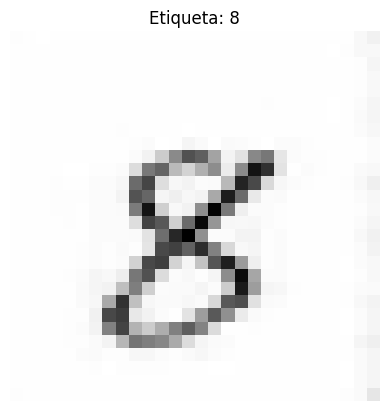

In [2]:

import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(X)-1)
image = X[idx].reshape(28, 28)
label = y[idx]

plt.imshow(image, cmap="gray")
plt.title(f"Etiqueta: {label}")
plt.axis("off")
plt.show()


## 4. División de datos en entrenamiento, validación y prueba

In [3]:

from sklearn.model_selection import train_test_split

# División 60% entrenamiento, 20% validación, 20% prueba, estratificada
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Prueba: {len(X_test)}")


Entrenamiento: 12933
Validación: 4311
Prueba: 4311


## 5. Optimización del Árbol de Decisión con GridSearchCV

In [5]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Para evitar problemas de memoria, usar una muestra del conjunto de entrenamiento
sample_size = 5000 if len(X_train) > 5000 else len(X_train)
idx_sample = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train[idx_sample]
y_train_sample = y_train[idx_sample]

param_grid = {
    "max_depth": [10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 5],
    "criterion": ["gini", "entropy"],
    "max_features": [None, "sqrt"]
}

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
grid_search.fit(X_train_sample, y_train_sample)

print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor precisión CV: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejores parámetros: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Mejor precisión CV: 0.3776


## 6. Evaluación final con mejor modelo

In [6]:

from sklearn.metrics import accuracy_score, classification_report

best_model = grid_search.best_estimator_

# Evaluar en conjunto de validación
y_val_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Precisión en validación: {val_acc:.4f}")

# Evaluar en conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Precisión en prueba: {test_acc:.4f}")

print("\nReporte de clasificación para prueba:")
print(classification_report(y_test, y_test_pred))


Precisión en validación: 0.3985
Precisión en prueba: 0.4029

Reporte de clasificación para prueba:
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       447
           1       0.54      0.55      0.55       448
           2       0.39      0.41      0.40       447
           3       0.33      0.36      0.34       441
           4       0.41      0.38      0.39       436
           5       0.33      0.33      0.33       425
           6       0.41      0.47      0.44       424
           7       0.37      0.41      0.39       423
           8       0.29      0.21      0.25       417
           9       0.29      0.24      0.26       403

    accuracy                           0.40      4311
   macro avg       0.40      0.40      0.40      4311
weighted avg       0.40      0.40      0.40      4311



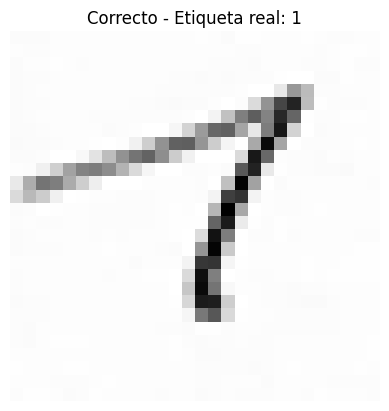

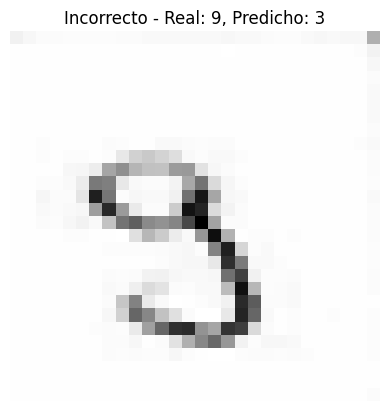

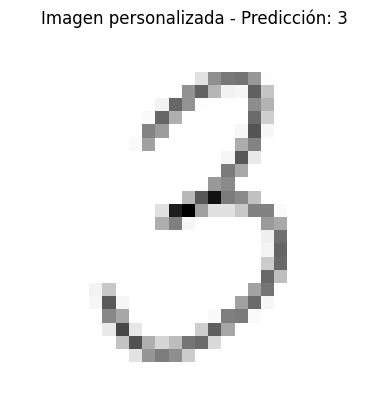

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Función para mostrar imagen con título
def mostrar_imagen(img_array, titulo):
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# 1. Imagen correctamente clasificada
y_pred = best_model.predict(X_test)

# Buscar índices de aciertos y errores
indices_correctos = np.where(y_pred == y_test)[0]
indices_incorrectos = np.where(y_pred != y_test)[0]

# Mostrar una imagen correcta aleatoria
idx_correcto = np.random.choice(indices_correctos)
mostrar_imagen(X_test[idx_correcto], f"Correcto - Etiqueta real: {y_test[idx_correcto]}")

# 2. Mostrar una imagen incorrecta aleatoria
idx_incorrecto = np.random.choice(indices_incorrectos)
mostrar_imagen(
    X_test[idx_incorrecto],
    f"Incorrecto - Real: {y_test[idx_incorrecto]}, Predicho: {y_pred[idx_incorrecto]}"
)

# 3. Cargar imagen personalizada y predecir
ruta_imagen_personal = "mi_imagen.png"  # Cambia esta ruta a la de tu imagen

# Cargar, convertir a escala de grises, redimensionar y a vector
img_personal = Image.open("numero.png").convert('L')
img_personal = img_personal.resize((28, 28))
img_personal_array = np.array(img_personal).flatten().reshape(1, -1)

# Predecir con el modelo
prediccion_personal = best_model.predict(img_personal_array)[0]
mostrar_imagen(img_personal_array, f"Imagen personalizada - Predicción: {prediccion_personal}")
